In [1]:
import numpy as np
import pandas as pd
import cv2
from skimage.feature import hog
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
from pathos.multiprocessing import ProcessingPool as Pool
%matplotlib inline

In [2]:
def augment_hls(image):
    img = np.copy(image)
    
#     img[:,:,0] = img[:,:,0]*(.25+np.random.uniform())
    img[:,:,1] = img[:,:,1]*(.25+np.random.uniform())
#     img[:,:,2] = img[:,:,2]*(.25+np.random.uniform())
    
    return img


In [3]:
def square_crop(image):
    long_side = max(image.shape[0], image.shape[1])
    short_side = min(image.shape[0], image.shape[1])
    
    xmin = max(0, int((image.shape[1] - image.shape[0]) / 2))
    xmax = min(image.shape[1], xmin + short_side)
    ymin = max(0, int((image.shape[0] - image.shape[1]) / 2))
    ymax = min(image.shape[0], ymin + short_side)
    
    return image[ymin:ymax, xmin:xmax]

In [4]:
import glob

notcar_names = glob.glob('./data/non-vehicles/Extras/*.png')
notcar_names.extend(glob.glob('./data/non-vehicles/GTI/*.png'))
notcar_names.extend(glob.glob('./data/non-vehicles_extra/*.jpg'))

car_names = glob.glob('./data/vehicles/GTI_Far/*.png')
car_names.extend(glob.glob('./data/vehicles/GTI_Left/*.png'))
car_names.extend(glob.glob('./data/vehicles/GTI_MiddleClose/*.png'))
car_names.extend(glob.glob('./data/vehicles/GTI_Right/*.png'))
car_names.extend(glob.glob('./data/vehicles/KITTI_extracted/*.png'))
car_names.extend(glob.glob('./data/vehicles_extra/*.jpg'))
car_names.extend(glob.glob('./data/udacity/vehicles/*.png'))
print("Number of car samples: {}".format(len(car_names)))
print("Number of not car samples: {}".format(len(notcar_names)))

Number of car samples: 73133
Number of not car samples: 9003


In [5]:
def load_img_data(filenames):
    def load_single_img(img_name):
        img = plt.imread(img_name)
        if img.dtype == 'float32':
            img = np.uint8(255 * img/np.max(img))
        
        img = square_crop(img)        
        img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        img = cv2.resize(img, (64, 64))
        return img
        
    pool = Pool(16)
    img_data = pool.map(load_single_img, filenames)
        
    return np.asarray(img_data)

In [6]:
car_img_data = load_img_data(car_names)
notcar_img_data = load_img_data(notcar_names)

In [7]:
def flip_images(img_data):
    flipped = []
    
    for img in img_data:
        flipped_img = np.fliplr(img)
        flipped.append(flipped_img)
        
    return np.asarray(flipped)

In [8]:
flipped_cars = flip_images(car_img_data)
flipped_notcars = flip_images(notcar_img_data)

In [9]:
car_img_data_combined = np.concatenate((car_img_data, flipped_cars), axis=0)
notcar_img_data_combined = np.concatenate((notcar_img_data, flipped_notcars), axis=0)

In [10]:
print(car_img_data_combined.shape)
print(notcar_img_data_combined.shape)

balance_ratio = int(car_img_data_combined.shape[0] / notcar_img_data_combined.shape[0])
print(balance_ratio)

(146266, 64, 64, 3)
(18006, 64, 64, 3)
8


In [11]:
data_X_img = np.concatenate((car_img_data_combined, np.repeat(notcar_img_data_combined, balance_ratio, axis=0)), axis=0)

In [12]:
print(data_X_img.shape)
print(data_X_img.dtype)

(290314, 64, 64, 3)
uint8


In [13]:
data_y = np.zeros((len(car_img_data_combined) + len(np.repeat(notcar_img_data_combined, 8, axis=0)), ))
data_y[:len(car_img_data_combined)] = 1

In [14]:
print(data_y.shape)

(290314,)


In [15]:
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y_one_hot = label_binarizer.fit_transform(data_y)

In [16]:
print(y_one_hot.shape)
print(y_one_hot[0])

(290314, 1)
[1]


In [17]:
def normalize_single_image(image):
    return (image - np.mean(image)) / (np.max(image) - np.min(image))

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_X_img, data_y, test_size=0.1, random_state=13)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=13)

In [19]:
# Normalize the test dataset
X_test_normalized = []

for img in X_test:
    img_normalized = normalize_single_image(img)
    X_test_normalized.append(img_normalized)

X_test_normalized = np.asarray(X_test_normalized)

In [20]:
def preprocess(image_data):
    img_augmented = augment_hls(image_data)
    img_normalized = normalize_single_image(img_augmented)
    img_normalized = np.asarray(img_normalized)

    return img_normalized

In [21]:
import random

def batch_generator(features, labels, batch_size):
    # Create empty arrays to contain batch of features and labels#
    batch_features = np.zeros((batch_size, 64, 64, 3))
    batch_labels = np.zeros((batch_size,),)
    
    while 1:
        for i in range(batch_size):
            #choose random index in features
            index = random.randint(0, len(features) - 1)
            
            batch_features[i] = preprocess(features[index])
            batch_labels[i] = labels[index]
            
        yield batch_features, batch_labels

In [22]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.advanced_activations import ELU, LeakyReLU
from keras.regularizers import l2, activity_l2
from keras.optimizers import Adam

def nvidia_model(image_dim, conv_drop=0.2, fc_drop=0.4):
    # image dim
    row, col, channel = image_dim
    
    # Regularization
    reg_val = 0.01
    
    model = Sequential()
        
    # Conv1
    model.add(Convolution2D(24, 5, 5, subsample=(2, 2), border_mode="valid", W_regularizer=l2(reg_val), input_shape=(row, col, channel)))
    model.add(ELU())
    model.add(Dropout(conv_drop))

    # Conv2
    model.add(Convolution2D(36, 5, 5, subsample=(2, 2), border_mode="valid"))
    model.add(ELU())
    model.add(Dropout(conv_drop))
    
    # Conv3
    model.add(Convolution2D(48, 5, 5, subsample=(2, 2), border_mode="valid"))
    model.add(ELU())
    model.add(Dropout(conv_drop))

    # Conv4
    model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode="valid"))
    model.add(ELU())
    model.add(Dropout(conv_drop))

    model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode="valid"))
    model.add(ELU())
    model.add(Dropout(conv_drop))
    
    model.add(Flatten())

#     model.add(Dense(100))
#     model.add(ELU())
#     model.add(Dropout(fc_drop))
    
    model.add(Dense(32))
    model.add(ELU())
    model.add(Dropout(fc_drop))
    
    model.add(Dense(16))
    model.add(ELU())
    
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    return model

Using TensorFlow backend.


In [43]:
# initialize generators
training_samples_gen = batch_generator(X_train, y_train, batch_size=500)
validation_samples_gen = batch_generator(X_val, y_val, batch_size=500)

# model = nvidia_model()
model = nvidia_model((64, 64, 3), conv_drop=0.2, fc_drop=0.4)
adam = Adam(lr=0.001)
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=adam)
history = model.fit_generator(training_samples_gen, samples_per_epoch=100000, nb_epoch=35, verbose=1, validation_data=validation_samples_gen, nb_val_samples=20000)

Epoch 1/35
100000/100000 [==============================] - 27s - loss: 0.4458 - acc: 0.8224 - val_loss: 0.3312 - val_acc: 0.8896
Epoch 2/35
100000/100000 [==============================] - 26s - loss: 0.3078 - acc: 0.9011 - val_loss: 0.2905 - val_acc: 0.9065
Epoch 3/35
100000/100000 [==============================] - 24s - loss: 0.2813 - acc: 0.9128 - val_loss: 0.2656 - val_acc: 0.9190
Epoch 4/35
100000/100000 [==============================] - 25s - loss: 0.2615 - acc: 0.9213 - val_loss: 0.2509 - val_acc: 0.9247
Epoch 5/35
100000/100000 [==============================] - 25s - loss: 0.2451 - acc: 0.9275 - val_loss: 0.2387 - val_acc: 0.9294
Epoch 6/35
100000/100000 [==============================] - 25s - loss: 0.2364 - acc: 0.9308 - val_loss: 0.2410 - val_acc: 0.9299
Epoch 7/35
100000/100000 [==============================] - 27s - loss: 0.2332 - acc: 0.9332 - val_loss: 0.2295 - val_acc: 0.9355
Epoch 8/35
100000/100000 [==============================] - 26s - loss: 0.2189 - acc: 0.93

dict_keys(['loss', 'val_loss', 'acc', 'val_acc'])


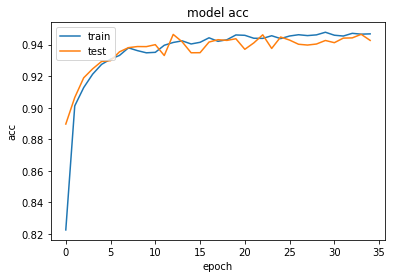

In [44]:
# list all data in history
print(history.history.keys())

# summarize history for loss
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model acc')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [45]:
y_one_hot_test = label_binarizer.fit_transform(y_test)

# TODO: Evaluate model on test data
metrics = model.evaluate(X_test_normalized, y_one_hot_test)
for metric_i in range(len(model.metrics_names)):
    metric_name = model.metrics_names[metric_i]
    metric_value = metrics[metric_i]
    print('{}: {}'.format(metric_name, metric_value))

29032/29032 [==============================] - 5s     
loss: 0.08229013566891659
acc: 0.9919399283549187


In [46]:
model.predict(X_test[0][None, :], batch_size=1)[0][0]

0.00099578826

In [47]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_16 (Convolution2D) (None, 30, 30, 24)    1824        convolution2d_input_4[0][0]      
____________________________________________________________________________________________________
elu_25 (ELU)                     (None, 30, 30, 24)    0           convolution2d_16[0][0]           
____________________________________________________________________________________________________
dropout_22 (Dropout)             (None, 30, 30, 24)    0           elu_25[0][0]                     
____________________________________________________________________________________________________
convolution2d_17 (Convolution2D) (None, 13, 13, 36)    21636       dropout_22[0][0]                 
___________________________________________________________________________________________

In [49]:
# import json
# with open('model.json', 'w') as outfile:
#     json.dump(model.to_json(), outfile)

# model.save_weights('model.h5')

In [23]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-nx_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

    
def search_windows(img, windows, keras_model):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        
        test_img = cv2.cvtColor(test_img,cv2.COLOR_RGB2HLS)
        img_normalized = normalize_single_image(test_img)
    
        prediction = keras_model.predict(img_normalized.reshape(1, 64, 64, 3), batch_size=1)[0][0]
        if prediction >= 0.5:
            on_windows.append(window)
            
    return on_windows

In [24]:
test_name1 = './test_images/test1.jpg'
test_name2 = './test_images/test2.jpg'
test_name3 = './test_images/test5.jpg'

test1 = plt.imread(test_name1)
test2 = plt.imread(test_name2)
test3 = plt.imread(test_name3)

In [25]:
def get_windows(image):
    windows1 = slide_window(image, x_start_stop=[700, None], y_start_stop=[415, 600], 
                        xy_window=(32, 32), xy_overlap=(0.5, 0.5))
    windows2 = slide_window(image, x_start_stop=[700, None], y_start_stop=[420, 550], 
                        xy_window=(48, 48), xy_overlap=(0.5, 0.5))
    windows3 = slide_window(image, x_start_stop=[730, None], y_start_stop=[400, 600], 
                        xy_window=(64, 64), xy_overlap=(0.6, 0.6))
    windows4 = slide_window(image, x_start_stop=[730, None], y_start_stop=[400, 650], 
                        xy_window=(96, 96), xy_overlap=(0.85, 0.85))
    windows5 = slide_window(image, x_start_stop=[780, None], y_start_stop=[400, 650], 
                        xy_window=(128, 128), xy_overlap=(0.85, 0.85))
    # windows6 = slide_window(test, x_start_stop=[780, None], y_start_stop=[400, 650], 
    #                     xy_window=(150, 150), xy_overlap=(0.85, 0.85))

    windows = []
    windows.extend(windows1)
    windows.extend(windows2)
    windows.extend(windows3)
    windows.extend(windows4)
    windows.extend(windows5)
    # windows.extend(windows6)
    return windows

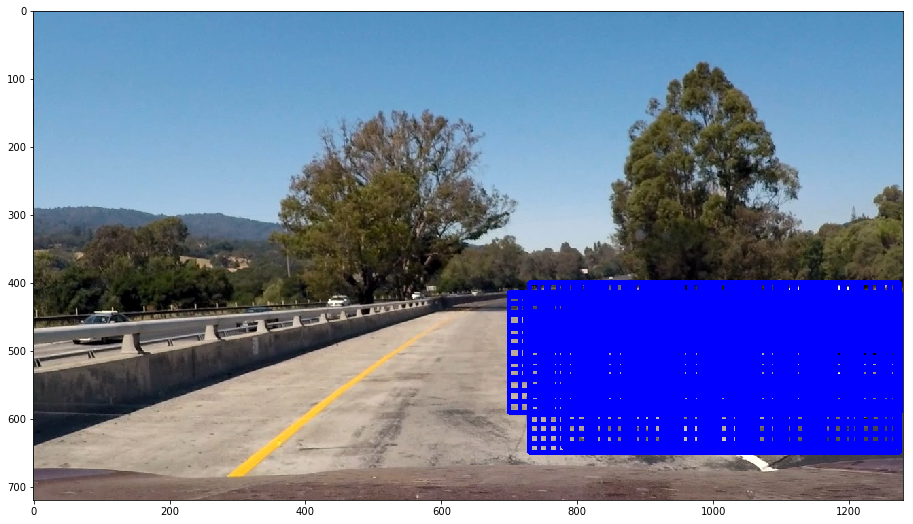

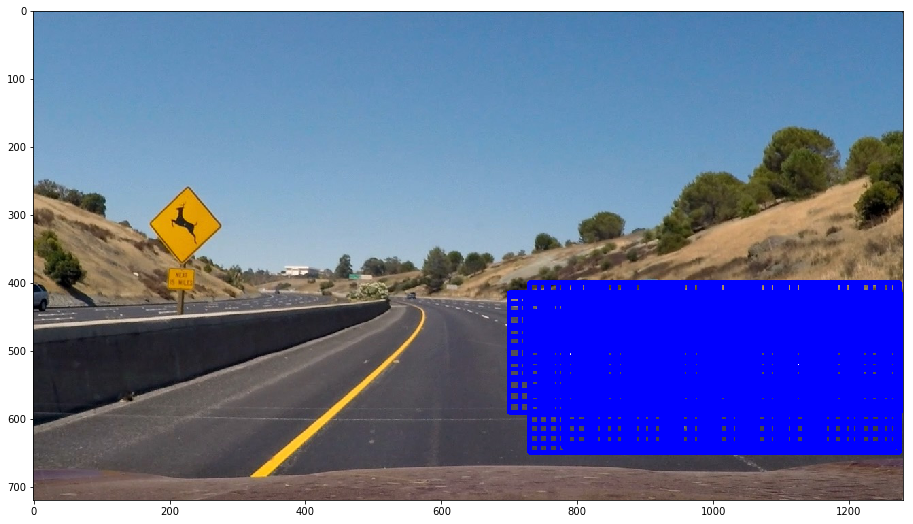

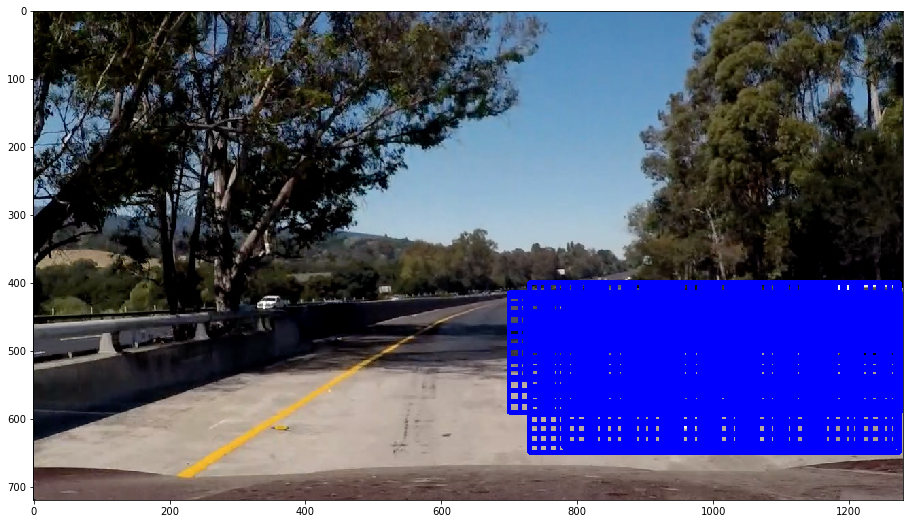

In [26]:
draw_image1 = np.copy(test1)
draw_image2 = np.copy(test2)
draw_image3 = np.copy(test3)

windows1 = get_windows(test1)
windows2 = get_windows(test2)
windows3 = get_windows(test3)

window_img1 = draw_boxes(draw_image1, windows1, color=(0, 0, 255), thick=6)
window_img2 = draw_boxes(draw_image2, windows2, color=(0, 0, 255), thick=6)
window_img3 = draw_boxes(draw_image3, windows3, color=(0, 0, 255), thick=6)

plt.figure(figsize=(16,9))
plt.imshow(window_img1)
plt.show()

plt.figure(figsize=(16,9))
plt.imshow(window_img2)
plt.show()

plt.figure(figsize=(16,9))
plt.imshow(window_img3)
plt.show()

In [27]:
import json
from keras.models import model_from_json

# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json.loads(json_file.read())
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights("model.h5")
print("Loaded model from disk")

Loaded model from disk


In [28]:
start_time = time.time()

hot_windows1 = search_windows(test1, windows1, model)
hot_windows2 = search_windows(test2, windows2, model) 
hot_windows3 = search_windows(test3, windows3, model) 

print("Predicting took {} seconds per frame.".format(time.time() - start_time))

Predicting took 10.651493310928345 seconds per frame.


In [29]:
window_img1 = draw_boxes(draw_image1, hot_windows1, color=(0, 110, 230), thick=3)
window_img2 = draw_boxes(draw_image2, hot_windows2, color=(0, 110, 230), thick=3)
window_img3 = draw_boxes(draw_image3, hot_windows3, color=(0, 110, 230), thick=3)

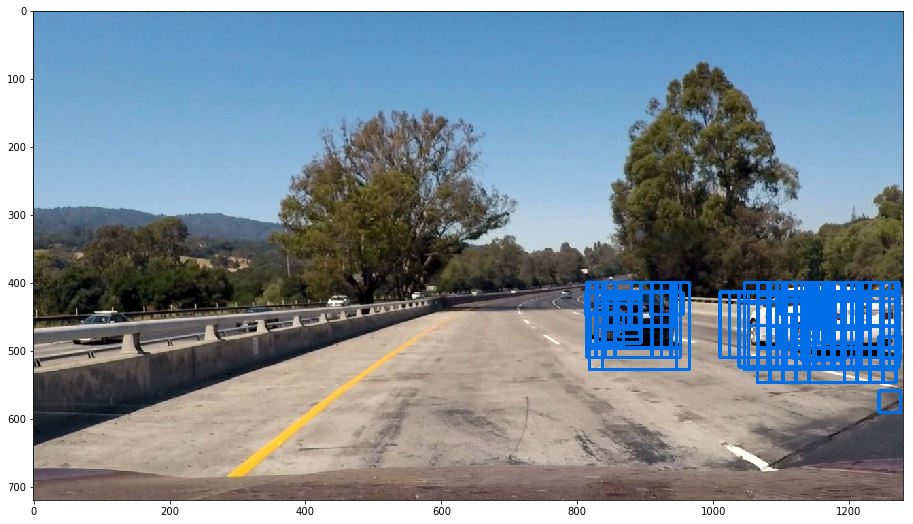

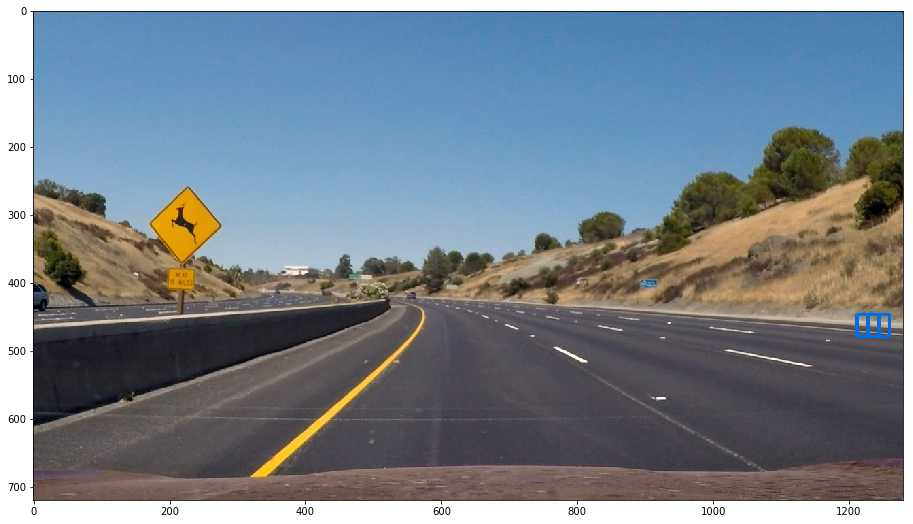

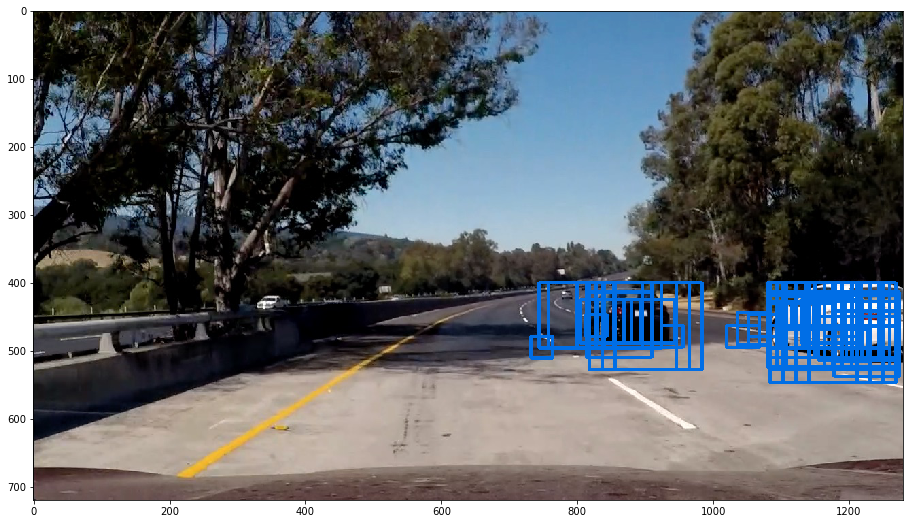

In [30]:
plt.figure(figsize=(16,9))
plt.imshow(window_img1)
plt.show()

plt.figure(figsize=(16,9))
plt.imshow(window_img2)
plt.show()

plt.figure(figsize=(16,9))
plt.imshow(window_img3)
plt.show()

In [31]:
from scipy.ndimage.measurements import label
import sys

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        try:
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        except ValueError:
            print(labels)
            print(nonzerox)
            print(nonzeroy)
            sys.exit()
            
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], color=(0, 110, 230), thickness=3)
    # Return the image
    return img

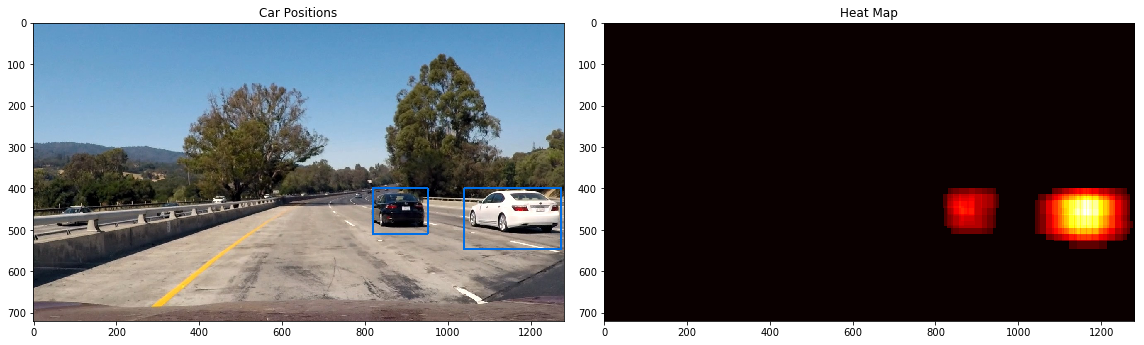

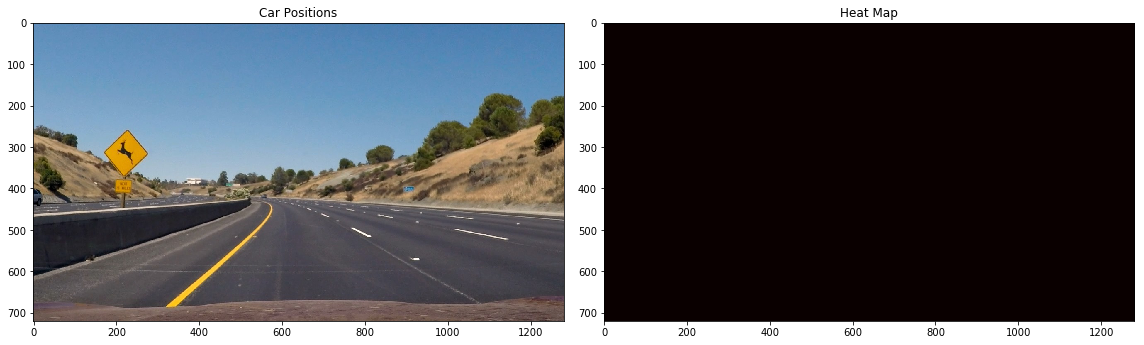

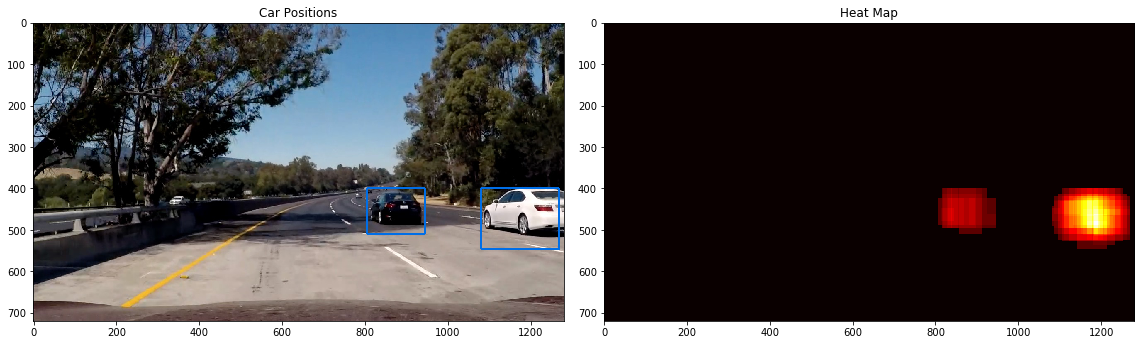

In [32]:
heat1 = np.zeros_like(test1[:,:,0]).astype(np.float)
heat2 = np.zeros_like(test2[:,:,0]).astype(np.float)
heat3 = np.zeros_like(test3[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat1 = add_heat(heat1, hot_windows1)
heat2 = add_heat(heat2, hot_windows2)
heat3 = add_heat(heat3, hot_windows3)
    
# Apply threshold to help remove false positives
heat1 = apply_threshold(heat1, 3)
heat2 = apply_threshold(heat2, 3)
heat3 = apply_threshold(heat3, 3)

# Visualize the heatmap when displaying    
heatmap1 = np.clip(heat1, 0, 255)
heatmap2 = np.clip(heat2, 0, 255)
heatmap3 = np.clip(heat3, 0, 255)

# Find final boxes from heatmap using label function
labels1 = label(heatmap1)
labels2 = label(heatmap2)
labels3 = label(heatmap3)

draw_img1 = draw_labeled_bboxes(np.copy(test1), labels1)
draw_img2 = draw_labeled_bboxes(np.copy(test2), labels2)
draw_img3 = draw_labeled_bboxes(np.copy(test3), labels3)

fig = plt.figure(figsize=(16, 9))
plt.subplot(121)
plt.imshow(draw_img1)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap1, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()
plt.show()

fig = plt.figure(figsize=(16, 9))
plt.subplot(121)
plt.imshow(draw_img2)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap2, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

fig = plt.figure(figsize=(16, 9))
plt.subplot(121)
plt.imshow(draw_img3)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap3, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

In [33]:
print(heat.nonzero())

NameError: name 'heat' is not defined

In [ ]:
print((labels[0] == 1).nonzero())

In [ ]:
import math

class CarTracker(object):
    def __init__(self, model, threshold=5, frame_window=10):
        self.model = model
        self.threshold = threshold
        self.frame_window = frame_window
        self.hot_windows = []
        self.frame_counter = 0
        self.labels_temp = None
        
    
    def pipeline(self, img):
        windows1 = slide_window(img, x_start_stop=[700, None], y_start_stop=[415, 600], 
                            xy_window=(32, 32), xy_overlap=(0.5, 0.5))
        windows2 = slide_window(img, x_start_stop=[700, None], y_start_stop=[420, 550], 
                            xy_window=(48, 48), xy_overlap=(0.5, 0.5))
        windows3 = slide_window(img, x_start_stop=[730, None], y_start_stop=[400, 600], 
                            xy_window=(64, 64), xy_overlap=(0.6, 0.6))
        windows4 = slide_window(img, x_start_stop=[730, None], y_start_stop=[400, 650], 
                            xy_window=(96, 96), xy_overlap=(0.85, 0.85))
        windows5 = slide_window(img, x_start_stop=[780, None], y_start_stop=[400, 650], 
                            xy_window=(128, 128), xy_overlap=(0.85, 0.85))
#         windows6 = slide_window(img, x_start_stop=[780, None], y_start_stop=[400, 650], 
#                             xy_window=(150, 150), xy_overlap=(0.85, 0.85))

        windows = []
        windows.extend(windows1)
        windows.extend(windows2)
        windows.extend(windows3)
        windows.extend(windows4)
        windows.extend(windows5)
#         windows.extend(windows6)
        
        self.hot_windows.extend(search_windows(img, windows, keras_model=self.model))
        
        heat = np.zeros_like(img[:,:,0]).astype(np.float)

        # Add heat to each box in box list
        heat = add_heat(heat, self.hot_windows)

        # Apply threshold to help remove false positives
        heat = apply_threshold(heat, self.threshold)

        # Visualize the heatmap when displaying    
        heatmap = np.clip(heat, 0, 255)

#         print("Counter: {}".format(self.frame_counter))
        
        if self.frame_counter == 0:
            # Find final boxes from heatmap using label function
            labels = label(heatmap)
            self.labels_temp = labels
            self.frame_counter += 1
    
        else:
            labels = self.labels_temp
            
            if self.frame_counter < self.frame_window:
                self.frame_counter += 1

            else:
                self.hot_windows = []
                self.frame_counter = 0
#                 print("reset")
        
        draw_img = draw_labeled_bboxes(np.copy(img), labels)
        
        return draw_img

In [42]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

car_tracker = CarTracker(model, threshold=7, frame_window=3)

white_output = 'p12.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(car_tracker.pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video p12.mp4
[MoviePy] Writing video p12.mp4


100%|█████████▉| 1260/1261 [1:18:23<00:03,  3.70s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: p12.mp4 

CPU times: user 1h 55min 37s, sys: 9min 2s, total: 2h 4min 40s
Wall time: 1h 18min 24s
